https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.033066

In [ ]:
!pip install h5py numpy gwpy

In [1]:
# Download LIGO data using gwosc (Gravitational Wave Open Science Center)
from gwpy.timeseries import TimeSeries
from pathlib import Path
import h5py
import numpy as np

def download_data(gps_start, duration, detector='H1', sample_rate=4096):
    # Download data directly from GWOSC
    print(f"Downloading {duration}s of {detector} data starting at GPS {gps_start}...")
    data = TimeSeries.fetch_open_data(
        detector, 
        gps_start, 
        gps_start + duration,
        sample_rate=sample_rate,
        cache=True  # Cache the data locally for faster future access
    )
    

    print(f"✓ Downloaded data successfully")
    print(f"  Duration: {data.duration.value} seconds")
    print(f"  Sample rate: {data.sample_rate.value} Hz")
    print(f"  Data shape: {data.value.shape}")

    # Optionally save to file for use with gwftools
    data_path = Path("data/")
    data_path.mkdir(exist_ok=True)
    output_file = data_path / f"{detector}-{gps_start}-{duration}.h5"

    with h5py.File(output_file, "w") as f:
        dset = f.create_dataset(f"{detector}:GDS-CALIB_STRAIN", data=data.value, compression="gzip")
        dset.attrs["sample_rate"] = sample_rate
        dset.attrs["t0"] = gps_start

    print(f"✓ Saved to {output_file}")
    
    return data

In [2]:
train_data = download_data(gps_start=1182410770, duration=1024)
test_data = download_data(gps_start=1182411794, duration=1024)

✓ Downloaded data successfully
  Duration: 1024.0 seconds
  Sample rate: 4096.0 Hz
  Data shape: (4194304,)
✓ Saved to data/H1-1182410770-1024.h5
✓ Downloaded data successfully
  Duration: 1024.0 seconds
  Sample rate: 4096.0 Hz
  Data shape: (4194304,)
✓ Saved to data/H1-1182411794-1024.h5


In [6]:
test_data.name

'Strain'

In [4]:
# Visualize LIGO data
import matplotlib.pyplot as plt
import numpy as np

def visualize_data(data):
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(3, 1, figsize=(14, 20))

    # 1. Time series plot (full duration)
    axes[0].plot(data.times.value, data.value, 'b-', linewidth=0.5)
    axes[0].set_xlabel('Time (s) from GPS start')
    axes[0].set_ylabel('Strain')
    axes[0].set_title(f'H1 Strain Data - Full 1024s')
    axes[0].grid(True, alpha=0.3)

    # 2. Zoomed time series (first 10 seconds)
    zoom_duration = 10
    zoom_mask = data.times.value <= (data.times.value[0] + zoom_duration)
    axes[1].plot(data.times.value[zoom_mask], data.value[zoom_mask], 'r-', linewidth=1)
    axes[1].set_xlabel('Time (s) from GPS start')
    axes[1].set_ylabel('Strain')
    axes[1].set_title(f'Zoomed View - First {zoom_duration} seconds')
    axes[1].grid(True, alpha=0.3)

    # 3. Power Spectral Density (PSD)
    psd = data.psd(fftlength=4, overlap=2)
    axes[2].loglog(psd.frequencies.value, np.sqrt(psd.value), 'g-', linewidth=1)
    axes[2].set_xlabel('Frequency (Hz)')
    axes[2].set_ylabel('Amplitude Spectral Density (1/√Hz)')
    axes[2].set_title('Power Spectral Density')
    axes[2].set_xlim(20, 1e3)
    axes[2].set_ylim(4e-23, 1e-21)
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

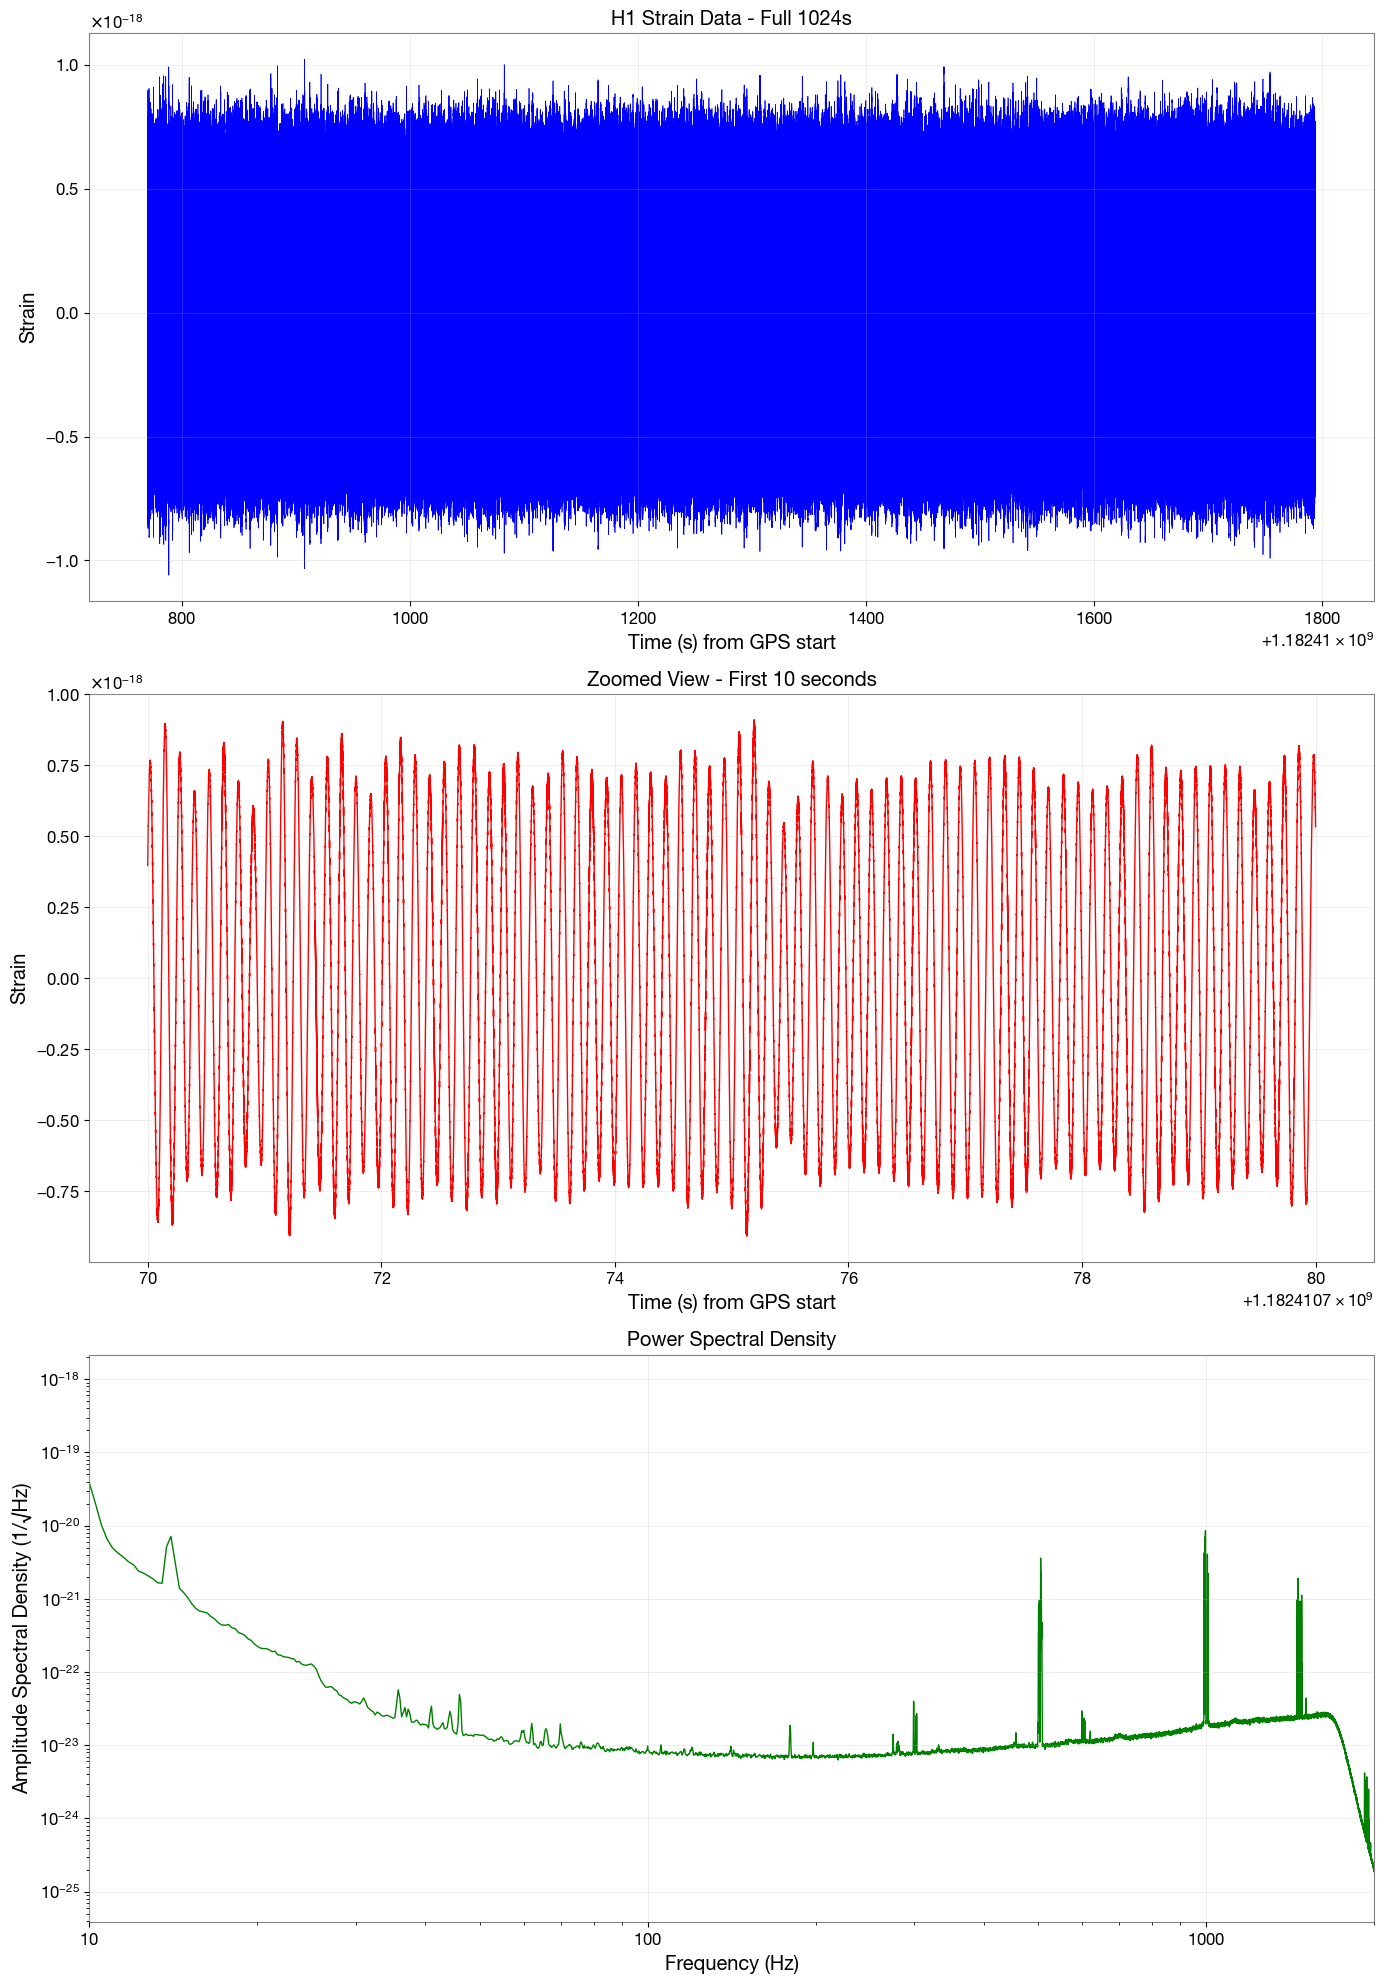

In [13]:
visualize_data(train_data)

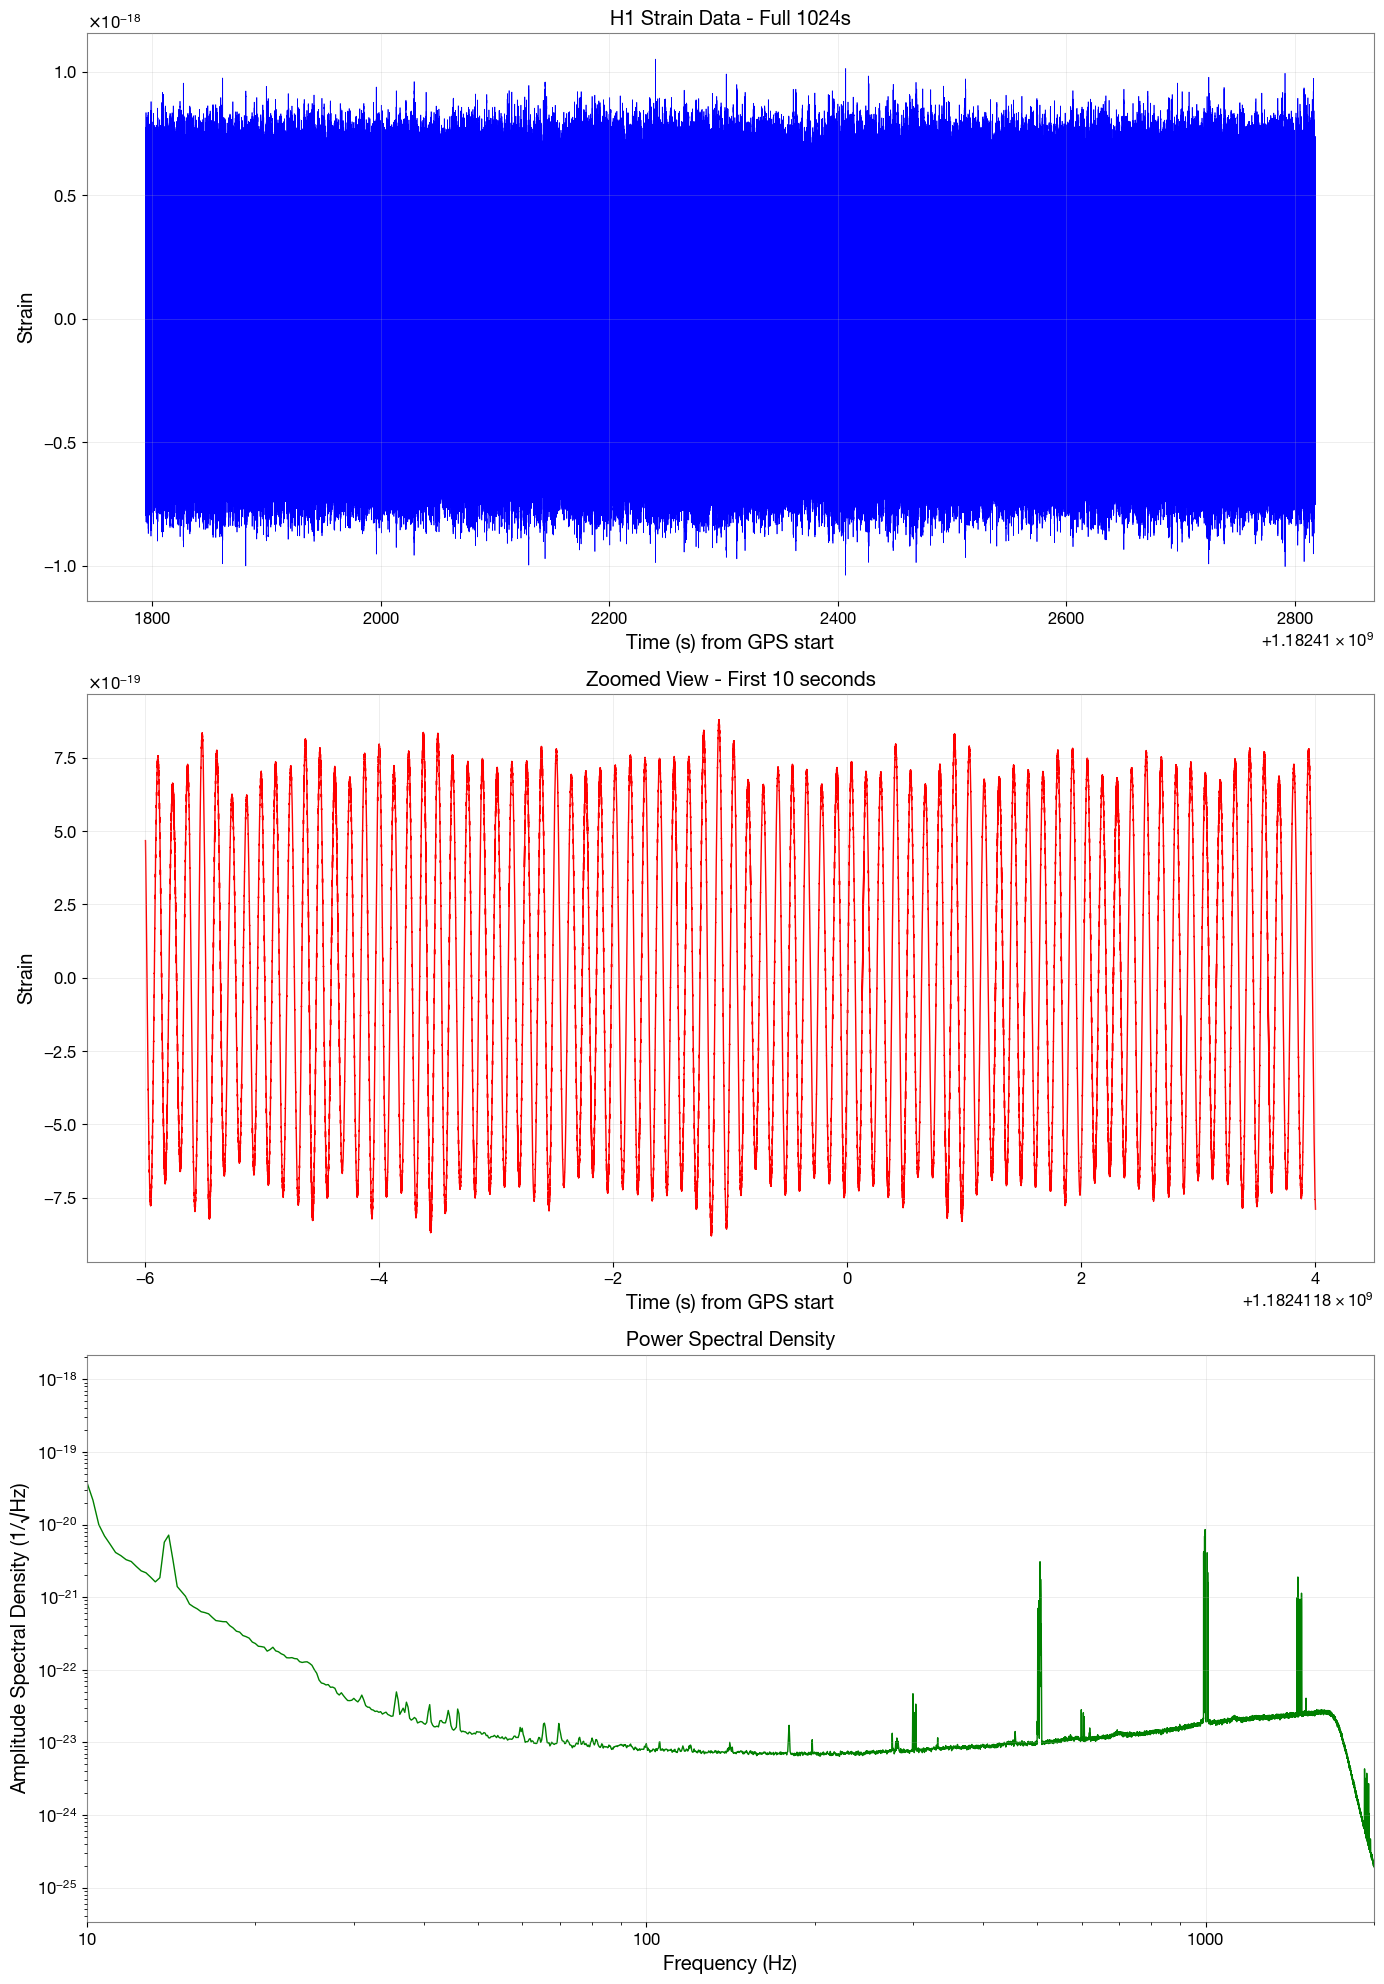

In [14]:
visualize_data(test_data)

In [20]:
from gwpy.timeseries import TimeSeries
from pathlib import Path
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Download raw O3 test data
o3_test_data = TimeSeries.fetch('H1:DCS-CALIB_STRAIN_C01_AR', start=1243983627, end=1243983727, host='nds.gwosc.org', sample_rate=4096)
# o3_test_data_clean = TimeSeries.fetch('H1:DCS-CALIB_STRAIN_CLEAN_SUB60HZ_C01_AR', start=1243983627, end=1243984727, host='nds.gwosc.org')

TypeError: TimeSeriesBase.fetch() got an unexpected keyword argument 'sample_rate'

In [22]:
# Load cleaned O3 test data from H-H1_GWOSC_O3a_4KHZ_R1-1243979776-4096.hdf5 file
o3_data_path = Path("data/H-H1_GWOSC_O3a_4KHZ_R1-1243979776-4096.hdf5")
with h5py.File(o3_data_path, "r") as f:
    # Print all dataset names to find the cleaned strain channel
    print("Datasets in the file:")
    for name in f:
        print(name)
    cleaned_data_values = f['strain/Strain'][:]
    # The Xspacing attribute is the time spacing between samples, not the sample rate
    # Sample rate = 1 / Xspacing
    time_spacing = f['strain/Strain'].attrs['Xspacing']
    sample_rate = 1.0 / time_spacing
    t0 = f['strain/Strain'].attrs['Xstart']
    print(f"\nSample rate: {sample_rate} Hz")
    print(f"Start time (GPS): {t0}")
    print(f"Total samples: {len(cleaned_data_values)}")
    print(f"Duration: {len(cleaned_data_values) / sample_rate} seconds")

# Create a TimeSeries object for the full cleaned data
o3_test_data_clean_full = TimeSeries(cleaned_data_values, t0=t0, sample_rate=sample_rate, name='H1:DCS-CALIB_STRAIN_CLEAN')

# Crop to match the time range of o3_test_data (100 seconds starting at GPS 1243983627)
start_time = 1243983627
end_time = 1243983727
o3_test_data_clean = o3_test_data_clean_full.crop(start_time, end_time)

print(f"\nCropped cleaned data:")
print(f"Duration: {o3_test_data_clean.duration.value} seconds")
print(f"Samples: {len(o3_test_data_clean)}")
print(f"Sample rate: {o3_test_data_clean.sample_rate.value} Hz")

Datasets in the file:
meta
quality
strain

Sample rate: 4096.0 Hz
Start time (GPS): 1243979776
Total samples: 16777216
Duration: 4096.0 seconds

Cropped cleaned data:
Duration: 100.0 seconds
Samples: 409600
Sample rate: 4096.0 Hz

Sample rate: 4096.0 Hz
Start time (GPS): 1243979776
Total samples: 16777216
Duration: 4096.0 seconds

Cropped cleaned data:
Duration: 100.0 seconds
Samples: 409600
Sample rate: 4096.0 Hz


In [ ]:
def visualize_o3_data(data):
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(1, 1, figsize=(14, 20))
    # Make the plot smaller
    fig.set_size_inches(14, 6)
    
    # Power Spectral Density (PSD)
    psd = data.psd(fftlength=4, overlap=2)
    axes.loglog(psd.frequencies.value, np.sqrt(psd.value), 'g-', linewidth=1)
    axes.set_xlabel('Frequency (Hz)')
    axes.set_ylabel('Amplitude Spectral Density (1/√Hz)')
    axes.set_title('Power Spectral Density')
    axes.set_xlim(57, 63)
    axes.set_ylim(1e-24, 1e-20)
    axes.grid(True, alpha=0.3)

def compare_o3_data(data1, data2):
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(1, 1, figsize=(14, 20))
    # Make the plot smaller
    fig.set_size_inches(14, 6)
    
    # Use appropriate fftlength for each dataset based on sample rate
    # fftlength should be a reasonable fraction of the total duration
    fftlength = 4  # 4 seconds
    overlap = 2    # 2 seconds (50% overlap)
    
    print(f"Data1: duration={data1.duration.value}s, sample_rate={data1.sample_rate.value}Hz")
    print(f"Data2: duration={data2.duration.value}s, sample_rate={data2.sample_rate.value}Hz")
    
    # Power Spectral Density (PSD) for data1
    psd1 = data1.psd(fftlength=fftlength, overlap=overlap)
    axes.loglog(psd1.frequencies.value, np.sqrt(psd1.value), 'g-', linewidth=1, label='Original Data')
    
    # Power Spectral Density (PSD) for data2
    psd2 = data2.psd(fftlength=fftlength, overlap=overlap)
    axes.loglog(psd2.frequencies.value, np.sqrt(psd2.value), 'b-', linewidth=1, label='Cleaned Data')
    
    axes.set_xlabel('Frequency (Hz)')
    axes.set_ylabel('Amplitude Spectral Density (1/√Hz)')
    axes.set_title('Power Spectral Density Comparison')
    axes.set_xlim(57, 63)
    axes.set_ylim(1e-24, 1e-20)
    axes.grid(True, alpha=0.3)
    axes.legend()

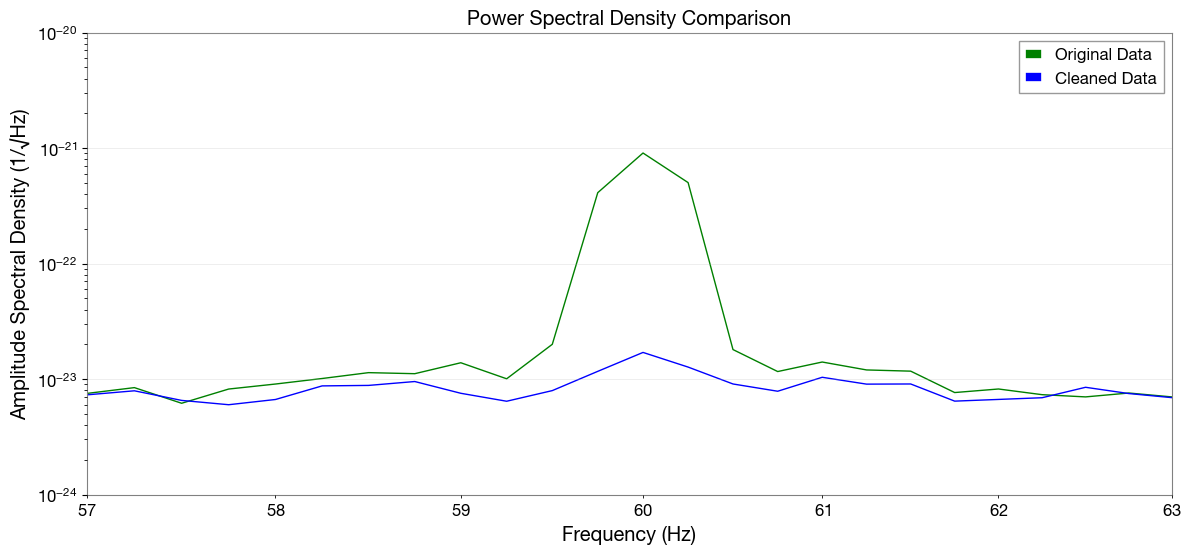

In [23]:
# visualize_o3_data(o3_test_data)
# visualize_o3_data(o3_test_data_clean)
compare_o3_data(o3_test_data, o3_test_data_clean)

In [19]:
# Check the data durations and sample rates
print(f"o3_test_data duration: {o3_test_data.duration.value}s, samples: {len(o3_test_data)}, sample rate: {o3_test_data.sample_rate.value}Hz")
print(f"o3_test_data_clean duration: {o3_test_data_clean.duration.value}s, samples: {len(o3_test_data_clean)}, sample rate: {o3_test_data_clean.sample_rate.value}Hz")

o3_test_data duration: 100.0s, samples: 1638400, sample rate: 16384.0Hz
o3_test_data_clean duration: 68719476736.0s, samples: 16777216, sample rate: 0.000244140625Hz
